# Classificação das imagens utilizando Vision Transformer (ViT)

## Arquitetura da Solução

## Dataset

O dataset escolhido está disponível no [link](https://www.kaggle.com/datasets/ahmedabdellahismail/covid-19-chest-x-ray/data), o qual é composto de **1196** imagens, pertencentes a três classes:

*   Covid
*   Virus
*   Normal



Segue abaixo o código necessário para realizar download do dataset, realizar unzip e excluir arquivos desnecessários:

In [ ]:
!kaggle datasets download -d ahmedabdellahismail/covid-19-chest-x-ray
!unzip /content/covid-19-chest-x-ray.zip
!rm /content/covid-19-chest-x-ray.zip

## Imports

In [ ]:
# !pip install torch
# !pip install torchinfo

In [ ]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import random
import torch
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
from torchvision import datasets, transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import torchvision
%matplotlib inline

In [ ]:
# selecionar a GPU caso exista
# ao selecionar a GPU, a tendencia é que o codigo seja executado mais rapidamente
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Transfer-Learning

### O que é?

É a técnica de utilizar um modelo pré-treinado para outra tarefa, a fim de adaptá-lo para ser a base para um outro modelo.

Nesse caso, utilizaremos o modelo ViT_B_16 para realizar classificação do presente dataset.

Treinar um modelo "*from scratch*" tornaria a tarefa de classificação muito menos acertiva, uma vez que a base de dados é pequena para tal, assim como a disponibilidade de recursos computacionais para treiná-lo.

### Overview

Primeiramente, serão carregados os pesos do modelo pré-treinado ViT_B_16, dessa forma, será utilizada uma técnica de **Transfer Learning**.


In [ ]:
pretrained_vit_w = torchvision.models.ViT_B_16_Weights.DEFAULT  # pesos pre-treinados ViT-Base

In [ ]:
print(pretrained_vit_w.transforms())  # transformações utilizadas no modelo-base

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## Pré-processamento dos dados

In [ ]:
# Define a transformação a ser aplicada nas imagens
transform = pretrained_vit_w.transforms()

# Carrega o dataset da pasta, assumindo que as subpastas são as classes
dataset = datasets.ImageFolder(root="/content/Data/", transform=transform)

# Defina a proporção de dados de treinamento e teste
train_ratio = 0.8

# Calcula os tamanhos dos conjuntos de treino e teste
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Divide o dataset em conjuntos de treino e teste
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Cria os data loaders para carregar os dados em mini-lotes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, pin_memory=True)

In [ ]:
# Conta a quantidade de imagens por classe no conjunto de treinamento
train_class_count = {}

for _, label in train_dataset:
    if label in train_class_count:
        train_class_count[label] += 1
    else:
        train_class_count[label] = 1
# Conta a quantidade de imagens por classe no conjunto de teste
test_class_count = {}
for _, label in test_dataset:
    if label in test_class_count:
        test_class_count[label] += 1
    else:
        test_class_count[label] = 1

# Mostra a quantidade de imagens por classe nos conjuntos de treinamento e teste
print(f'Tamanho do conjunto de treino: {len(train_loader.dataset)}')
print("Quantidade de imagens por classe no conjunto de treinamento:")
for class_idx, count in train_class_count.items():
    print(f"Classe {class_idx}: {count} imagens")

print(f'\nTamanho do conjunto de teste: {len(test_loader.dataset)}')
print("Quantidade de imagens por classe no conjunto de teste:")
for class_idx, count in test_class_count.items():
    print(f"Classe {class_idx}: {count} imagens")


Tamanho do conjunto de treino: 956
Quantidade de imagens por classe no conjunto de treinamento:
Classe 2: 353 imagens
Classe 0: 238 imagens
Classe 1: 365 imagens

Tamanho do conjunto de teste: 240
Quantidade de imagens por classe no conjunto de teste:
Classe 1: 103 imagens
Classe 2: 80 imagens
Classe 0: 57 imagens


## Definindo nosso modelo

In [ ]:
pretrained_vit = torchvision.models.vit_b_16(    #utilizando o modelo-base, com os pesos padrao do modelo
    weights=pretrained_vit_w
    ).to(device)

class_names = dataset.classes #[covid, normal, virus]

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

torch.manual_seed(42)
torch.cuda.manual_seed(42)

pretrained_vit.heads = nn.Linear(in_features=768, #16x16x3 = 768
                                 out_features=len(class_names)
                                 ).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 178MB/s]


In [ ]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

ModuleNotFoundError: No module named 'torchinfo'

## Treino e Teste

In [ ]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    # colocar o modelo em modo de treinamento
    model.train()

    # inicializar valores com 0
    train_loss, train_acc = 0, 0

    # loop sobre os batches
    for batch, (X, y) in enumerate(dataloader):
        # enviar os dados para o device

        X, y = X.to(device), y.to(device)

        # forward
        y_pred = model(X)

        # calcular loss (e acumular)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # resetar o gradiente do otimizador antes do backpropagation
        optimizer.zero_grad()


        loss.backward()

        # ativar o otimizador
        optimizer.step()

        # calcular acuracia sobre os batches

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # ajustar as metricas para a media dos batches
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # coloca o modelo em modo eval
    model.eval()

    # iniciar valores com 0
    test_loss, test_acc = 0, 0

    # ligar inference context manager
    with torch.inference_mode():
        # loop sobre os batches
        for batch, (X, y) in enumerate(dataloader):
            # enviar os dados para o device
            X, y = X.to(device), y.to(device)

            # forward
            test_pred_logits = model(X)

            # calcular e "acumular" loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # calcular acuracia sobre os batches
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # ajustar as metricas para a media dos batches
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # resultados
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    model.to(device)

    # loop pelos passos de treino e teste de acordo com o numero de epocas definido
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # print para cada epoca
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [ ]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()
# setar seeds manualmente
torch.manual_seed(42)
torch.cuda.manual_seed(42)

pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_loader,
                                      test_dataloader=test_loader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6248 | train_acc: 0.7624 | test_loss: 0.3302 | test_acc: 0.8945
Epoch: 2 | train_loss: 0.2954 | train_acc: 0.9122 | test_loss: 0.2300 | test_acc: 0.9414
Epoch: 3 | train_loss: 0.2372 | train_acc: 0.9329 | test_loss: 0.2021 | test_acc: 0.9453
Epoch: 4 | train_loss: 0.2071 | train_acc: 0.9414 | test_loss: 0.1740 | test_acc: 0.9492
Epoch: 5 | train_loss: 0.1920 | train_acc: 0.9496 | test_loss: 0.1602 | test_acc: 0.9570
Epoch: 6 | train_loss: 0.1746 | train_acc: 0.9487 | test_loss: 0.1484 | test_acc: 0.9609
Epoch: 7 | train_loss: 0.1625 | train_acc: 0.9540 | test_loss: 0.1414 | test_acc: 0.9453
Epoch: 8 | train_loss: 0.1495 | train_acc: 0.9580 | test_loss: 0.1388 | test_acc: 0.9648
Epoch: 9 | train_loss: 0.1398 | train_acc: 0.9583 | test_loss: 0.1310 | test_acc: 0.9609
Epoch: 10 | train_loss: 0.1329 | train_acc: 0.9632 | test_loss: 0.1293 | test_acc: 0.9453


## Resultados

In [ ]:
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


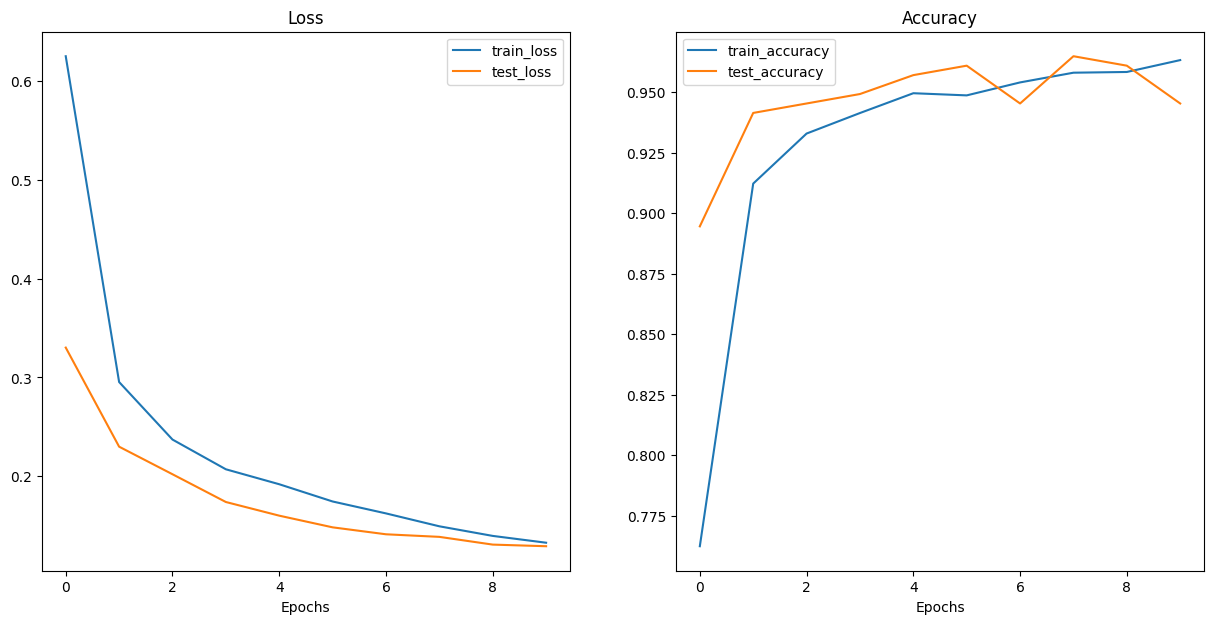

In [ ]:
plot_loss_curves(pretrained_vit_results)